# Teste de algoritmos de detecção de faces

In [1]:
import numpy as np
import pandas as pd

# processamento de imagem
import cv2
from PIL import Image
import torch
import torchvision as tvis

# vis
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/home/itsmeale/code/face-verification/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregando uma amostra das imagens

In [124]:
images_files = pd.read_parquet("../data/interim/images_paths.parquet").sort_values(by=["img"]).iloc[:25]

In [125]:
sample = images_files.values.flatten()
images = [tvis.io.read_image(f"../{path}") for path in sample]

In [126]:
# Resolução das imagens
print(set([im.shape for im in images]))

{torch.Size([3, 250, 250])}


Todas as imagens já estão na mesma resolução

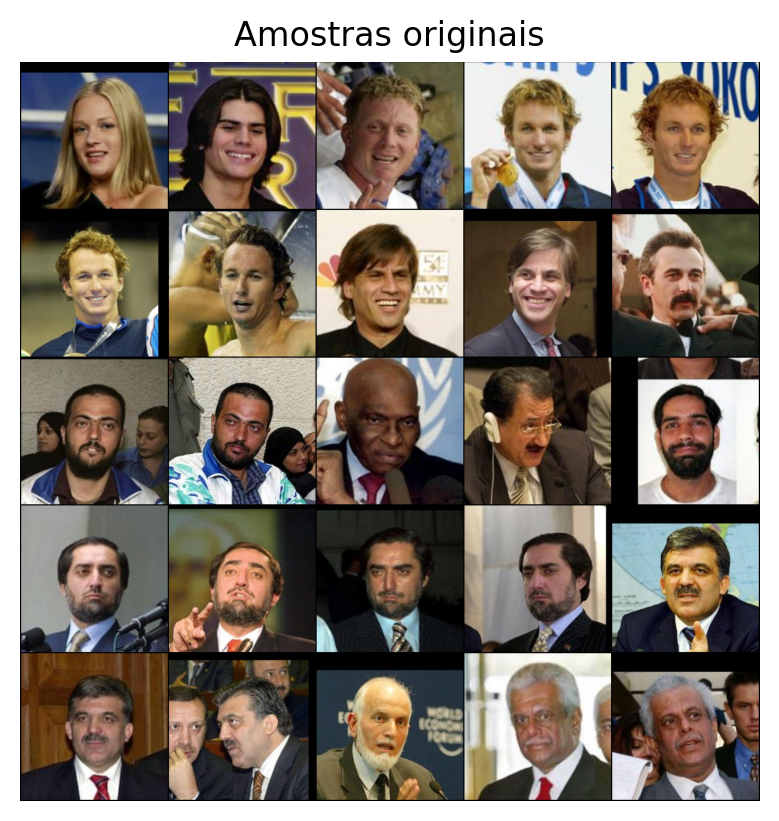

In [127]:
fig, ax = plt.subplots(dpi=200)
plt.imshow(tvis.utils.make_grid(images, nrow=5).permute((1, 2, 0)))
plt.axis(False)
plt.title("Amostras originais")
plt.show()

Aplicação do algoritmo de Viola & Jones com Haar cascades pré-treinadas

In [128]:
permuted_image = images[6].permute((1, 2, 0))

# converte imagem para escala de cinza
gray = cv2.cvtColor(permuted_image.numpy(), cv2.COLOR_BGR2GRAY)

# carrega o detector com as cascades pré-treinadas
detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# detecção das faces
faces = detector.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=3, flags=cv2.CASCADE_DO_CANNY_PRUNING)

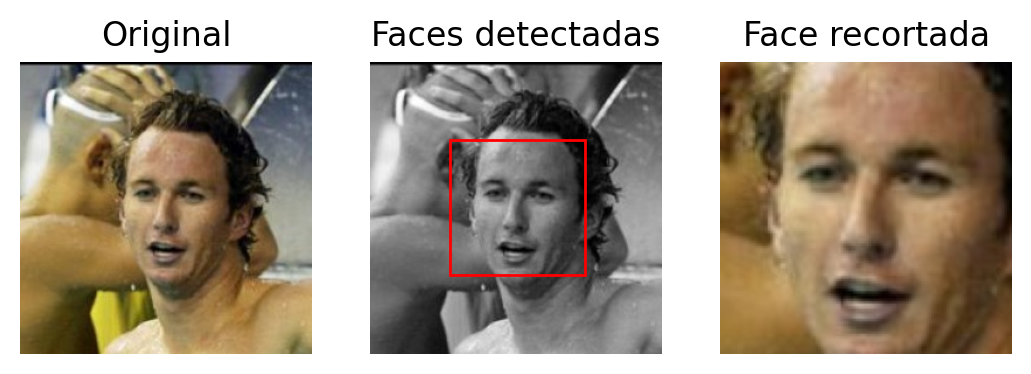

In [129]:
fig, ax = plt.subplots(1, 3, dpi=200)
x, y, w, h = faces[0]

rect1 = patches.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')

ax[0].imshow(permuted_image)
ax[0].axis(False)
ax[0].set_title("Original")

ax[1].imshow(gray, cmap='gray')
ax[1].axis(False)
ax[1].add_patch(rect1)
ax[1].set_title("Faces detectadas")

ax[2].imshow(permuted_image[x:x+w, y:y+h])
ax[2].axis(False)
ax[2].set_title("Face recortada")

plt.show()

---

# Avaliação do VJ

In [130]:
import json
import pandas as pd

In [131]:
def evaluate_detected_faces(path: str):
    with open(path, "r") as j:
        faces = json.loads(j.read())

    files = list(faces.keys())
    images_found = list()
    total_images = len(files)

    for f in files:
        images_found.append(len(faces[f]))
        
    unique_values, counts = np.unique(images_found, return_counts=True)
    
    print(pd.DataFrame({"values": unique_values, "counts": counts}))
        
    return faces

def evaluate_detected_faces_dict(faces: dict):
    files = list(faces.keys())
    images_found = list()
    total_images = len(files)

    for f in files:
        images_found.append(len(faces[f]))
        
    unique_values, counts = np.unique(images_found, return_counts=True)
    
    print(pd.DataFrame({"values": unique_values, "counts": counts}))
        
    return faces

In [132]:
faces_dict = evaluate_detected_faces("../data/interim/detected_faces.json")

   values  counts
0       1    2571
1       2    1622
2       3     560
3       4     168
4       5      50
5       6      12
6       7       2
7       8       4
8       9       2
9      10       1


---

## Eliminação de múltiplas faces detectadas e não desejadas

Para resolver o problema de múltiplas faces detectadas, removeremos todas
as bounding boxes que não contêm o pixel central da imagem.

In [133]:
def filter_face(faces):
    for face in faces:
        x, y, w, h = face
        in_x = x <= 125 <= (x+w)
        in_y = y <= 125 <= (y+h)
        if in_x and in_y:
            return face
    return list()

In [134]:
filtered_faces = {
    path: filter_face(faces)
    for path, faces in faces_dict.items()
}

filtered_faces_valid = {
    path: faces
    for path, faces in filtered_faces.items()
    if len(faces) > 0
}

In [146]:
filtered_faces_valid = dict(sorted(filtered_faces_valid.items(), key=lambda k: k[0]))

In [147]:
f = evaluate_detected_faces_dict(filtered_faces)

   values  counts
0       0       3
1       4    4989


In [148]:
def cut_image(img: np.array, bbox:list):
    x, y, w, h = bbox
    return img[x:x+w, y:y+h]

In [149]:
valid_imgs = [
    torch.as_tensor(cv2.resize(cut_image(np.asarray(Image.open(f"../{path}")), bbox), dsize=(150, 150))).permute((2, 0, 1))
    for path, bbox in filtered_faces_valid.items()
]

In [150]:
valid_imgs_tensor = valid_imgs[:25]

In [151]:
shapes = set()
for i in valid_imgs:
    shapes.add(i.shape)

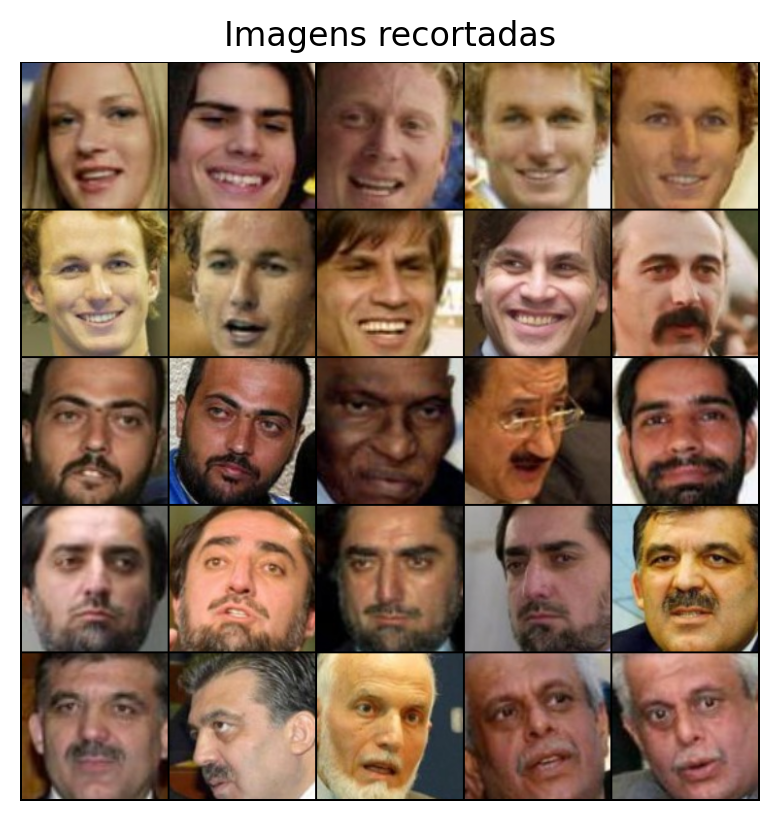

In [152]:
fig, ax = plt.subplots(dpi=200)
plt.imshow(tvis.utils.make_grid(valid_imgs_tensor, nrow=5).permute((1, 2, 0)))
plt.axis(False)
plt.title("Imagens recortadas")
plt.show()

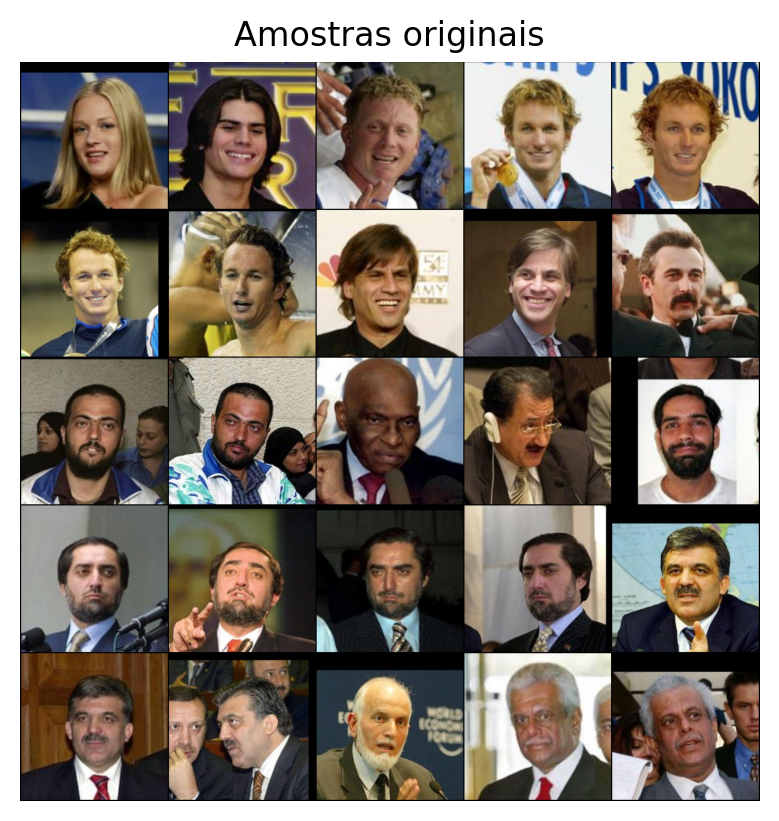

In [153]:
fig, ax = plt.subplots(dpi=200)
plt.imshow(tvis.utils.make_grid(images, nrow=5).permute((1, 2, 0)))
plt.axis(False)
plt.title("Amostras originais")
plt.show()

---

### Faces mal detectadas

In [110]:
imgs = [
    k
    for k, v in filtered_faces.items()
    if len(v) == 0
]

In [111]:
imgs

['data/raw/lfw/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0001.jpg',
 'data/raw/lfw/Dereck_Whittenburg/Dereck_Whittenburg_0001.jpg',
 'data/raw/lfw/Lawrence_Foley/Lawrence_Foley_0001.jpg']

In [113]:
ims = [tvis.io.read_image(f"../{f}") for f in imgs]

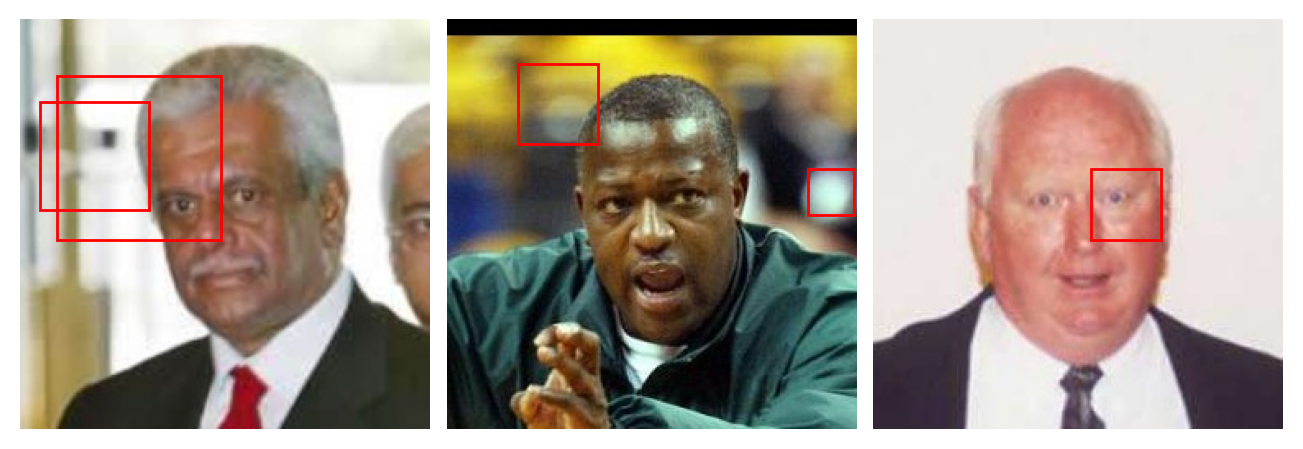

In [123]:
fig, axes = plt.subplots(1, 3, dpi=200, constrained_layout = True)

for i in range(len(ims)):
    ax = axes[i]
    permuted_image = ims[i].permute((1, 2, 0))

    # converte imagem para escala de cinza
    gray = cv2.cvtColor(permuted_image.numpy(), cv2.COLOR_BGR2GRAY)

    # carrega o detector com as cascades pré-treinadas
    detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # detecção das faces
    faces = detector.detectMultiScale(
        gray,
        scaleFactor=1.02,
        minNeighbors=3,
        flags=cv2.CASCADE_DO_CANNY_PRUNING
    )

    ax.imshow(ims[i].permute((1, 2, 0)))

    for face in faces:
        x, y, w, h = face
        rect = patches.Rectangle((x, y), w, h, facecolor="none", edgecolor='r')
        ax.add_patch(rect)

    ax.axis(False)
    
plt.show()

As 3 faces que não foram bem identificadas serão eliminadas do conjunto de dados original.